In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

class TaxIllCalculator1:
    def __init__(self, periods=30, beginning_balance=1000, beginning_cost=0, div_rate=0.33, 
                 st_tax=0.37, lt_tax=0.20, investment_return_rate=0.07, port_turnover=0.25, liquidation=False, st_port_liq = False, st_bench_liq = False):
        self.periods = periods
        self.beginning_balance = beginning_balance
        self.beginning_cost = beginning_cost if beginning_cost else beginning_balance
        self.div_rate = div_rate
        self.st_tax = st_tax
        self.lt_tax = lt_tax
        self.investment_return_rate = investment_return_rate
        self.port_turnover = port_turnover
        self.liquidation = liquidation
        self.st_port_liq = st_port_liq
        self.st_bench_liq = st_bench_liq

        self.lt_tax_adj = lt_tax * (1 - port_turnover)
        self.st_tax_adj = st_tax * port_turnover
        
        # Initialize lists for results
        self.results = {
            "portfolio": {
                "beginning_balances": [],
                "investment_returns": [],
                "div_incs": [],
                "beginning_cost_basis": [],
                "realized_gls": [],
                "tax_costs": [],
                "ending_cost_basis": [],
                "ending_balances": []
            },
            "benchmark": {
                "beginning_balances": [],
                "cost_basis": [],
                "investment_returns": [],
                "div_incs": [],
                "realized_gls": [],
                "tax_costs": [],
                "ending_cost_basis": [],
                "ending_balances": []
            }
        }
                
    def calculate_portfolio(self):
        beginning_balance = self.beginning_balance
        beginning_cost = self.beginning_cost

        for i in range(self.periods):
            # Portfolio calculations
            investment_return = beginning_balance * self.investment_return_rate
            div_inc = investment_return * self.div_rate
            realized_gl = (investment_return - div_inc) * self.port_turnover / 2 + (beginning_balance - beginning_cost) * self.port_turnover

            tax_cost = div_inc * self.lt_tax + realized_gl * self.lt_tax_adj + realized_gl * self.st_tax_adj
            ending_cost = beginning_cost + realized_gl + div_inc - tax_cost
            ending_balance = beginning_balance + investment_return - tax_cost

            if i == self.periods - self.periods and self.st_port_liq:
                # Liquidation at the first period
                lrealized_gl =  (beginning_balance - beginning_cost)
                srealized_gl = (investment_return - div_inc) * self.port_turnover / 2
                tax_cost = div_inc * self.lt_tax + lrealized_gl * self.lt_tax + srealized_gl * self.st_tax
                ending_cost = beginning_cost + srealized_gl + lrealized_gl + div_inc - tax_cost
                ending_balance = beginning_balance + investment_return - tax_cost
                
            if i == self.periods - 1 and self.liquidation:
                # Liquidation at the final period
                realized_gl = (investment_return - div_inc) + (beginning_balance - beginning_cost)
                tax_cost = div_inc * self.lt_tax + realized_gl * self.lt_tax_adj + realized_gl * self.st_tax_adj
                ending_cost = beginning_cost + realized_gl + div_inc - tax_cost
                ending_balance = beginning_balance + investment_return - tax_cost

            # Storing the results for portfolio
            self.store_portfolio_results(i, beginning_balance, beginning_cost, investment_return, div_inc, realized_gl, tax_cost, ending_cost, ending_balance)

            # Update balances for the next period
            beginning_balance = ending_balance
            beginning_cost = ending_cost

    def store_portfolio_results(self, i, beginning_balance, beginning_cost, investment_return, div_inc, realized_gl, tax_cost, ending_cost, ending_balance):
        # Store the portfolio results
        self.results["portfolio"]["beginning_balances"].append(beginning_balance)
        self.results["portfolio"]["beginning_cost_basis"].append(beginning_cost)
        self.results["portfolio"]["investment_returns"].append(investment_return)
        self.results["portfolio"]["div_incs"].append(div_inc)
        self.results["portfolio"]["realized_gls"].append(realized_gl)
        self.results["portfolio"]["tax_costs"].append(tax_cost)
        self.results["portfolio"]["ending_cost_basis"].append(ending_cost)
        self.results["portfolio"]["ending_balances"].append(ending_balance)

    def calculate_benchmark(self):
        benchmark_begin_bal = self.beginning_balance
        benchmark_cost = self.beginning_cost

        for i in range(self.periods):
            benchmark_investment_return = benchmark_begin_bal * self.investment_return_rate
            benchmark_div_inc = benchmark_investment_return * self.div_rate
            benchmark_realized_gl = 0  # No realized gain/loss due to zero turnover
            benchmark_tax_cost = benchmark_div_inc * self.lt_tax
            benchmark_end_cost = benchmark_cost + benchmark_div_inc - benchmark_tax_cost
            benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
            
            if i == self.periods - self.periods and self.st_bench_liq:
                benchmark_realized_gl = benchmark_begin_bal - benchmark_cost
                benchmark_tax_cost = benchmark_div_inc * self.lt_tax + benchmark_realized_gl * self.lt_tax
                benchmark_end_cost = benchmark_cost + benchmark_realized_gl + benchmark_div_inc - benchmark_tax_cost
                benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost
            
            if i == self.periods - 1 and self.liquidation:
                benchmark_realized_gl = (benchmark_investment_return - benchmark_div_inc) + (benchmark_begin_bal - benchmark_cost)
                benchmark_tax_cost = benchmark_div_inc * self.lt_tax + benchmark_realized_gl * self.lt_tax
                benchmark_end_cost = benchmark_cost + benchmark_realized_gl + benchmark_div_inc - benchmark_tax_cost
                benchmark_ending_balance = benchmark_begin_bal + benchmark_investment_return - benchmark_tax_cost

            # Storing the results for benchmark
            self.store_benchmark_results(i, benchmark_begin_bal, benchmark_cost, benchmark_investment_return, benchmark_div_inc, benchmark_realized_gl, benchmark_tax_cost, benchmark_end_cost, benchmark_ending_balance)

            # Update balances for the next period
            benchmark_begin_bal = benchmark_ending_balance
            benchmark_cost = benchmark_end_cost

    def store_benchmark_results(self, i, benchmark_begin_bal, benchmark_cost, benchmark_investment_return, benchmark_div_inc, benchmark_realized_gl, benchmark_tax_cost, benchmark_end_cost, benchmark_ending_balance):
        # Store the benchmark results
        self.results["benchmark"]["beginning_balances"].append(benchmark_begin_bal)
        self.results["benchmark"]["cost_basis"].append(benchmark_cost)
        self.results["benchmark"]["investment_returns"].append(benchmark_investment_return)
        self.results["benchmark"]["div_incs"].append(benchmark_div_inc)
        self.results["benchmark"]["realized_gls"].append(benchmark_realized_gl)
        self.results["benchmark"]["tax_costs"].append(benchmark_tax_cost)
        self.results["benchmark"]["ending_cost_basis"].append(benchmark_end_cost)
        self.results["benchmark"]["ending_balances"].append(benchmark_ending_balance)

    def calculate_breakeven_performance(self):
        # Required Breakeven Performance Calculation
        required_return_rate = self.investment_return_rate
        tolerance = 1e-6  # Convergence tolerance
        max_iterations = 1000

        beginning_balance = self.results["portfolio"]["beginning_balances"][0]
        beginning_cost = self.results["portfolio"]["beginning_cost_basis"][0]
        benchmark_ending_balance = self.results["benchmark"]["ending_balances"][-1]
        periods = self.periods

        for _ in range(max_iterations):
            test_balance = beginning_balance
            test_cost = beginning_cost

            for i in range(periods):
                test_return = test_balance * required_return_rate
                test_div_inc = test_return * self.div_rate
                test_realized_gl = (test_return - test_div_inc) * self.port_turnover / 2 + (test_balance - test_cost) * self.port_turnover
                test_tax_cost = test_div_inc * self.lt_tax + test_realized_gl * self.lt_tax_adj + test_realized_gl * self.st_tax_adj

                if i == periods - periods and self.st_port_liq:
                    # Liquidation at the final period
                    test_realized_gl = (test_return - test_div_inc) + (test_balance - test_cost)
                    test_tax_cost = test_div_inc * self.lt_tax + test_realized_gl * self.lt_tax 
                    
                if i == periods - 1 and self.liquidation:
                    # Liquidation at the final period
                    test_realized_gl = (test_return - test_div_inc) + (test_balance - test_cost)
                    test_tax_cost = test_div_inc * self.lt_tax + test_realized_gl * self.lt_tax_adj + test_realized_gl * self.st_tax_adj

                test_cost += test_realized_gl + test_div_inc - (test_div_inc * self.lt_tax)
                test_balance += test_return - test_tax_cost

            if abs(test_balance - benchmark_ending_balance) < tolerance:
                break

            # Adjust the return rate for the next iteration
            if test_balance < benchmark_ending_balance:
                required_return_rate += 0.00001  # Increase the rate slightly
            else:
                required_return_rate -= 0.00001  # Decrease the rate slightly

        # Calculate performances
        pat_perf = ((self.results["portfolio"]["ending_balances"][-1] / self.results["portfolio"]["beginning_balances"][0])**(1/periods)) - 1
        bat_perf = ((self.results["benchmark"]["ending_balances"][-1] / self.results["benchmark"]["beginning_balances"][0])**(1/periods)) - 1

        req_alpha = required_return_rate - bat_perf

        # Store the results
        self.required_return_rate = required_return_rate
        self.req_alpha = req_alpha
        self.pat_perf = pat_perf
        self.bat_perf = bat_perf

    def plot_results(self):
        portfolio_end_balances = self.results["portfolio"]["ending_balances"]
        benchmark_end_balances = self.results["benchmark"]["ending_balances"]

        plt.figure(figsize=(10, 6))
        plt.plot(portfolio_end_balances, marker='o', linestyle='-', color='b', label='Portfolio with Turnover')
        plt.plot(benchmark_end_balances, marker='o', linestyle='--', color='r', label='Benchmark (0 Turnover)')
        plt.title('Ending Balance Over Periods')
        plt.xlabel('Period')
        plt.ylabel('Ending Balance')
        plt.grid(True)
        plt.legend()
        plt.show()

    def display_summary(self):
        # Calculate the ending value difference
        end_val_dif = abs(self.results["portfolio"]["ending_balances"][-1] - self.results["benchmark"]["ending_balances"][-1])

        # Create a DataFrame for the summary
        df_summary = pd.DataFrame({
            'Ending Balance': [self.results["portfolio"]["ending_balances"][-1]],
            'Benchmark Ending Balance (0 Turnover)': [self.results["benchmark"]["ending_balances"][-1]],
            'Ending Value Difference': [end_val_dif],
            'Portfolio Annualized After Tax Performance': [self.pat_perf],
            'Benchmark Annualized After Tax Performance': [self.bat_perf],
            'Portfolio Required Breakeven Performance': [self.required_return_rate],
            'Portfolio Required Annualized Alpha': [self.req_alpha],
        })

        # Format the DataFrame
        df_summary['Ending Balance'] = df_summary['Ending Balance'].apply(lambda x: "${:,.2f}".format(x))
        df_summary['Benchmark Ending Balance (0 Turnover)'] = df_summary['Benchmark Ending Balance (0 Turnover)'].apply(lambda x: "${:,.2f}".format(x))
        df_summary['Ending Value Difference'] = df_summary['Ending Value Difference'].apply(lambda x: "${:,.2f}".format(x))
        df_summary['Portfolio Annualized After Tax Performance'] = df_summary['Portfolio Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
        df_summary['Benchmark Annualized After Tax Performance'] = df_summary['Benchmark Annualized After Tax Performance'].apply(lambda x: "{:.2%}".format(x))
        df_summary['Portfolio Required Breakeven Performance'] = df_summary['Portfolio Required Breakeven Performance'].apply(lambda x: "{:.2%}".format(x))
        df_summary['Portfolio Required Annualized Alpha'] = df_summary['Portfolio Required Annualized Alpha'].apply(lambda x: "{:.2%}".format(x))

        display(df_summary)

    def display_full_results(self):
        # Combine portfolio and benchmark results into a DataFrame
        df = pd.DataFrame({
            'Period': range(1, self.periods + 1),
            'Beginning Balance': self.results["portfolio"]["beginning_balances"],
            'Beginning Cost Basis': self.results["portfolio"]["beginning_cost_basis"],
            'Investment Return': self.results["portfolio"]["investment_returns"],
            'Dividend Income': self.results["portfolio"]["div_incs"],
            'Realized Gain/Loss': self.results["portfolio"]["realized_gls"],
            'Tax Cost': self.results["portfolio"]["tax_costs"],
            'Ending Cost Basis': self.results["portfolio"]["ending_cost_basis"],
            'Ending Balance': self.results["portfolio"]["ending_balances"],
            'Benchmark Beginning Balance': self.results["benchmark"]["beginning_balances"],
            'Benchmark Cost Basis': self.results["benchmark"]["cost_basis"],
            'Benchmark Investment Return': self.results["benchmark"]["investment_returns"],
            'Benchmark Dividend Income': self.results["benchmark"]["div_incs"],
            'Benchmark Realized Gain/Loss': self.results["benchmark"]["realized_gls"],
            'Benchmark Tax Cost': self.results["benchmark"]["tax_costs"],
            'Benchmark Ending Cost Basis': self.results["benchmark"]["ending_cost_basis"],
            'Benchmark Ending Balance': self.results["benchmark"]["ending_balances"],
        })

        display(df)




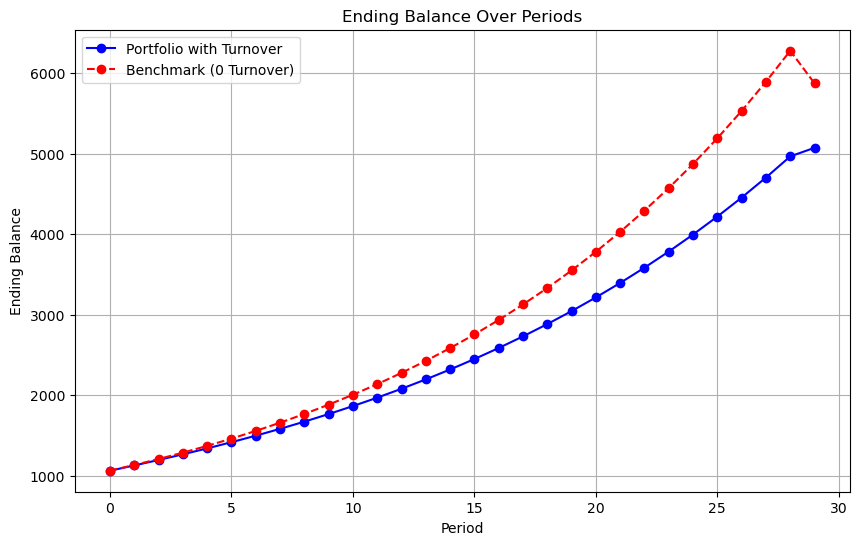

,Ending Balance,Benchmark Ending Balance (0 Turnover),Ending Value Difference,Portfolio Annualized After Tax Performance,Benchmark Annualized After Tax Performance,Portfolio Required Breakeven Performance,Portfolio Required Annualized Alpha
0,"$5,070.83","$5,869.84",$799.01,5.56%,6.08%,7.45%,1.37%


,Period,Beginning Balance,Beginning Cost Basis,Investment Return,Dividend Income,Realized Gain/Loss,Tax Cost,Ending Cost Basis,Ending Balance,Benchmark Beginning Balance,Benchmark Cost Basis,Benchmark Investment Return,Benchmark Dividend Income,Benchmark Realized Gain/Loss,Benchmark Tax Cost,Benchmark Ending Cost Basis,Benchmark Ending Balance
0,1,1000.000000,1000.000000,70.000000,23.100000,5.862500,6.041656,1022.920844,1063.958344,1000.000000,1000.000000,70.000000,23.100000,0.000000,4.620000,1018.480000,1065.380000
1,2,1063.958344,1022.920844,74.477084,24.577438,16.496831,8.915969,1055.079143,1129.519459,1065.380000,1018.480000,74.576600,24.610278,0.000000,4.922056,1038.168222,1135.034544
2,3,1129.519459,1055.079143,79.066362,26.091899,25.231887,11.337112,1095.065817,1197.248708,1135.034544,1038.168222,79.452418,26.219298,0.000000,5.243860,1059.143661,1209.243103
3,4,1197.248708,1095.065817,83.807410,27.656445,32.564593,13.428203,1141.858653,1267.627915,1209.243103,1059.143661,84.647017,27.933516,0.000000,5.586703,1081.490473,1288.303417
4,5,1267.627915,1141.858653,88.733954,29.282205,38.873784,15.283334,1194.731308,1341.078536,1288.303417,1081.490473,90.181239,29.759809,0.000000,5.951962,1105.298320,1372.532694
5,6,1341.078536,1194.731308,93.875497,30.978914,44.448880,16.974636,1253.184466,1417.979397,1372.532694,1105.298320,96.077289,31.705505,0.000000,6.341101,1130.662725,1462.268882
6,7,1417.979397,1253.184466,99.258558,32.755324,49.511637,18.557637,1316.893790,1498.680318,1462.268882,1130.662725,102.358822,33.778411,0.000000,6.755682,1157.685454,1557.872021
7,8,1498.680318,1316.893790,104.907622,34.619515,54.232645,20.075320,1385.670631,1583.512621,1557.872021,1157.685454,109.051042,35.986844,0.000000,7.197369,1186.474929,1659.725694
8,9,1583.512621,1385.670631,110.845883,36.579142,58.743840,21.561210,1459.432403,1672.797294,1659.725694,1186.474929,116.180799,38.339664,0.000000,7.667933,1217.146659,1768.238560
9,10,1672.797294,1459.432403,117.095811,38.641618,63.147997,23.041713,1538.180305,1766.851392,1768.238560,1217.146659,123.776699,40.846311,0.000000,8.169262,1249.823708,1883.845997


In [116]:
calc = TaxIllCalculator1(periods=30, beginning_balance=1000, liquidation = True)
calc.calculate_portfolio()
calc.calculate_benchmark()
calc.calculate_breakeven_performance()
calc.plot_results()
calc.display_summary()
calc.display_full_results()